In [1]:
seed = 42
valid_test_size = 0.2
maxlen = 100 # length of one training sample by words
vector_len = 100 # length of embedding vectors for each word

## `Problem Statement`

*   IMDb Movie Reviews is many to one problem.
*   Text Sentiment Analysis with RNN.
*   pre-trained Glove Embeddings.



## `IMPORTS`

In [2]:
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import  stopwords
from sklearn.model_selection import train_test_split
from zipfile import ZipFile


## `Get and visualize the Dataset`

In [3]:
!gdown 1He6pot7hsWfSURS0Kh-MlmDyQqfRUUdd

Downloading...
From: https://drive.google.com/uc?id=1He6pot7hsWfSURS0Kh-MlmDyQqfRUUdd
To: /content/a1_IMDB_Dataset.csv
100% 66.2M/66.2M [00:00<00:00, 72.8MB/s]


In [4]:
# Little bit statistics
df_reviews = pd.read_csv('/content/a1_IMDB_Dataset.csv')
print(df_reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


- Dataset hasn't missing values, so no need for Data cleaning step

In [5]:
# Print first 5 rows
print(df_reviews.head(5))

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


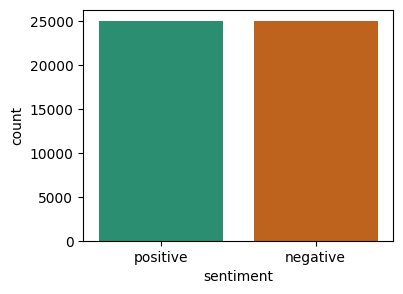

In [6]:
# Visualizing of positive/negative sentiments in dataset
plt.figure(figsize=(4,3))
sns.countplot(x='sentiment', data=df_reviews, palette=sns.palettes.mpl_palette('Dark2')[0:2], hue='sentiment');

In [7]:
print(df_reviews["review"][0])


One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

- We will need to deals with **punctuations**, brackets, HTML tags and numbers

## `STEP: DATA SPLIT`

In [8]:
df_reviews_train, df_reviews_test = train_test_split(df_reviews, test_size=valid_test_size, random_state=seed)
df_reviews_valid, df_reviews_test = train_test_split(df_reviews_test, test_size=0.5, random_state=seed)

print(df_reviews_train.shape, df_reviews_test.shape, df_reviews_valid.shape, sep=', ')

(40000, 2), (5000, 2), (5000, 2)


## `STEP: DATA PRE-PROCESSING`

In [9]:
def parse_function(text, cls, language='english'):

    text = text.lower()
    # for html tags
    html_tags_regex = re.compile(r'<[^>]+>')
    # for punctuations
    punctuations_regex = re.compile(r'[^a-z0-9\s]+')
    # for words that contains numbers like f4g
    words_contains_numbers_regex = re.compile(r'\w*\d+\w*')
    # for urls and links
    urls_regex = re.compile(r'https?:\/\/\s+|www\.\s+')
    # for stopwords
    nltk.download('stopwords', quiet=True)
    stopwords_regex = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    # for multiple spaces and newlines
    multi_space_regex = re.compile(r'\n+|\s+')

    text = html_tags_regex.sub(' ', text)
    text = punctuations_regex.sub(' ', text)
    text = words_contains_numbers_regex.sub(' ', text)
    text = urls_regex.sub(' ', text)
    text = stopwords_regex.sub(' ', text)
    text = multi_space_regex.sub(' ', text)
    text = text.strip()

    label=0
    if cls == 'positive':
        label = 1

    return text, label


## function to map preprocess_function for al rows for a dataframe
def mymap(df_reviews, lang='english'):
    prepro_reviews = {'reviews':[], 'labels':[]}

    for text, cls in df_reviews.values:
        review, label = parse_function(text, cls)
        prepro_reviews['reviews'].append(review)
        prepro_reviews['labels'].append(label)

    return prepro_reviews

In [10]:
# Calling preprocess_function on reviews
df_prepro_reviews_train = pd.DataFrame(mymap(df_reviews_train))
df_prepro_reviews_valid = pd.DataFrame(mymap(df_reviews_valid))
df_prepro_reviews_test = pd.DataFrame(mymap(df_reviews_test))


In [11]:
x_train = df_prepro_reviews_train['reviews'].values
y_train = df_prepro_reviews_train['labels'].values

x_valid = df_prepro_reviews_valid['reviews'].values
y_valid = df_prepro_reviews_valid['labels'].values

x_test = df_prepro_reviews_test['reviews'].values
y_test = df_prepro_reviews_test['labels'].values

print(x_train.shape, x_valid.shape, x_test.shape, y_train.shape, y_valid.shape, y_test.shape, sep=', ')

(40000,), (5000,), (5000,), (40000,), (5000,), (5000,)


### Tokenization and Padding step

In [12]:
### Tokenization step
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(x_train)

x_train = word_tokenizer.texts_to_sequences(x_train)
x_valid = word_tokenizer.texts_to_sequences(x_valid)
x_test = word_tokenizer.texts_to_sequences(x_test)

In [13]:
vocab_size = len(word_tokenizer.word_index) + 1
print(vocab_size)

90613


In [14]:
# Padding all reviews to fixed length, if you will truncate then truncate latest words as for many times first words contain

X_train = pad_sequences(x_train, padding='post', truncating='post', maxlen=maxlen)
X_valid = pad_sequences(x_valid, padding='post', truncating='post', maxlen=maxlen)
X_test = pad_sequences(x_test, padding='post', truncating='post', maxlen=maxlen)

### Form Embedding matrix step

In [20]:
### Embedding step

# download and load pre-trained embedding weights
!cp '/content/drive/MyDrive/DataSets-and-Models/glove.6B.zip' '/content/'

with ZipFile('/content/glove.6B.zip') as file:
    file.extract('glove.6B.100d.txt')

In [21]:
# form an embedding matrix form glove pre-trained embedding weights for my vocab
glove_embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(glove_embeddings_index))

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in word_tokenizer.word_index.items():
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print("Embedding matrix shape: " ,embedding_matrix.shape)

Loaded 400000 word vectors.
Embedding matrix shape:  (90613, 100)


In [22]:
i=90002
print(word_tokenizer.sequences_to_texts([[i]]))
print(embedding_matrix[i])

['technocrat']
[-0.64616001  0.32962     0.66737002  0.016801   -0.17502999 -0.065344
  0.45765999 -0.82059997  0.11549     1.28559995 -0.91706997  0.22985999
  0.28560999  0.036869    0.64337999 -0.10304     0.26278001 -0.40893999
  0.54491001  0.058445   -0.30429     0.80046999 -0.56788999 -1.34560001
  0.04228    -0.41119999 -0.53609002 -0.10216    -0.47139999 -0.11201
 -0.0086239   0.48425999 -0.66461998 -0.68282002  0.43956     0.74883997
 -0.36093    -0.83109999 -0.012142   -0.42688     0.022329    0.2405
  0.54672003  0.017101    0.56026    -0.60991001  0.31336999  0.12178
 -0.37077001  0.13461    -0.88024002 -0.30087     0.35690999  0.65152001
 -0.25784999  0.046017   -0.064452    0.42897001 -0.24862     0.19238999
  0.15706    -0.43233001 -0.59292001 -0.11925    -0.082742   -0.1531
  0.45460001  0.077898    0.38257     0.18278     0.032703   -0.086026
 -0.39585    -0.31341001 -0.42691001 -0.74557    -0.70718002  0.21468
  0.90656    -1.25049996  0.67786998  0.51481998  0.19307

## `STEP: MODELS TRAINING && Evaluation`

In [35]:
# Define Model architecture

input = keras.layers.Input((100,))
x = keras.layers.Embedding(input_dim=vocab_size, output_dim=vector_len, weights=[embedding_matrix], input_length=maxlen, trainable=False)(input)
x = keras.layers.LSTM(units=128)(x)
x = keras.layers.Dense(units=128, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
output = keras.layers.Dense(units=1, activation='sigmoid')(x)

rnn_model = keras.models.Model(input, output)

# Model compiling
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
rnn_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 100, 100)          9061300   
                                                                 
 lstm_2 (LSTM)               (None, 128)               117248    
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9195189 (35.08 MB)
Trainable params: 133889 (

In [36]:
# Model Training
rnn_model_history = rnn_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=128, epochs=15, verbose=1)

Epoch 1/15
313/313 [==============================] - 8s 13ms/step - loss: 0.5299 - acc: 0.7378 - val_loss: 0.4527 - val_acc: 0.7860
Epoch 2/15
313/313 [==============================] - 3s 9ms/step - loss: 0.4274 - acc: 0.8092 - val_loss: 0.4337 - val_acc: 0.7920
Epoch 3/15
313/313 [==============================] - 3s 9ms/step - loss: 0.3858 - acc: 0.8323 - val_loss: 0.3737 - val_acc: 0.8388
Epoch 4/15
313/313 [==============================] - 3s 9ms/step - loss: 0.3505 - acc: 0.8511 - val_loss: 0.3741 - val_acc: 0.8390
Epoch 5/15
313/313 [==============================] - 3s 10ms/step - loss: 0.3327 - acc: 0.8588 - val_loss: 0.3545 - val_acc: 0.8460
Epoch 6/15
313/313 [==============================] - 4s 11ms/step - loss: 0.3146 - acc: 0.8672 - val_loss: 0.3348 - val_acc: 0.8528
Epoch 7/15
313/313 [==============================] - 3s 9ms/step - loss: 0.2940 - acc: 0.8779 - val_loss: 0.3417 - val_acc: 0.8448
Epoch 8/15
313/313 [==============================] - 3s 9ms/step - loss:

In [37]:
# Evaluation on the Test Set
score = rnn_model.evaluate(X_test, y_test, verbose=1)

157/157 [==============================] - 1s 4ms/step - loss: 0.5470 - acc: 0.8414


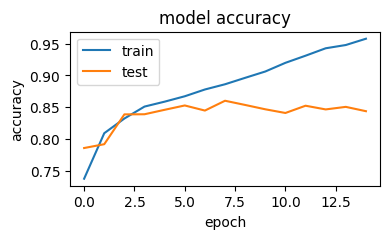

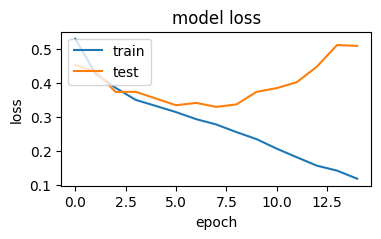

In [38]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.figure(figsize=(4,2))
plt.plot(rnn_model_history.history['acc'])
plt.plot(rnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.figure(figsize=(4,2))
plt.plot(rnn_model_history.history['loss'])
plt.plot(rnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [39]:
# Saving the model as a h5 file for possible use later
rnn_model.save(f"./lstm_model.keras", save_format='keras')